<a href="https://colab.research.google.com/github/ymuto0302/RW2025/blob/main/sinewave_prediciton_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
# import pandas as pd

# デバイス設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

device: cpu


## ノイズ付き正弦波データの生成
1. 0から100の範囲で n_points 個の等間隔の時間点を作成
1. 各時間点で sin 関数を計算
1. ガウシアンノイズを追加する

In [2]:
'''
ノイズ付き正弦波データを生成する関数
引数: n_points: データポイント数
          noise_level: ノイズレベル
'''
def generate_sine_wave_data(n_points=1000, noise_level=0.1):
    # 0から100の範囲で等間隔の時間軸を作成
    t = np.linspace(0, 100, n_points)

    # 正弦波を計算し，ガウシアンノイズを追加
    # (メモ) np.random.normal() は平均0，標準偏差1の正規分布に従う乱数を生成
    data = np.sin(t) + noise_level * np.random.normal(size=n_points)

    return data

## 時系列データ用の PyTorch データセットクラス
- 時系列データを「入力シーケンス→出力値」のペアに変換
- 例: [t1,t2,t3,t4,t5] → t6 の予測問題に変換

`data = [1,2,3,4,5,6,7,8,9,10]`, sequence_length=3の場合：
- インデックス0: [1,2,3] → 4
- インデックス1: [2,3,4] → 5
- インデックス2: [3,4,5] → 6

In [3]:
# データセットクラス
class SineWaveDataset(Dataset):
    '''
    初期化メソッド
        Args:
            data: 時系列データ（１次元データ）
            sequence_length: 入力シーケンス長
    '''
    def __init__(self, data, sequence_length=10):
        self.data = data
        self.sequence_length = sequence_length

    # データセットのサイズを返す
    def __len__(self):
        return len(self.data) - self.sequence_length

    # 指定されたインデックスの1つのサンプル（入力-出力ペア）を返す
    def __getitem__(self, idx):
        # 過去 sequence_length 時点のデータ
        x = self.data[idx:idx + self.sequence_length]

        # 次の1時点のデータ（予測対象）
        y = self.data[idx + self.sequence_length]

        return torch.FloatTensor(x).unsqueeze(-1), torch.FloatTensor([y])

## LSTMモデルクラス
アーキテクチャ： 入力 → LSTM層 → 全結合層 → 出力


In [4]:
# LSTMモデル
class SineWaveLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_size=1):
        '''
        初期化メソッド
        Args:
            input_size: 入力特徴量数
            hidden_size: 隠れ状態の次元数
            num_layers: LSTM層数
            output_size: 出力次元数
        '''
        super(SineWaveLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM層
        self.lstm = nn.LSTM(
            input_size=input_size,        # 各時点での特徴量数
            hidden_size=hidden_size,  # 隠れ状態の次元数
            num_layers=num_layers,    # LSTM の層数
            batch_first=True                  # 入力テンソルの形状を(batch, seq, feature)にする
        )

        # 出力層(全結合層)
        self.fc = nn.Linear(hidden_size, output_size)

    # 順伝搬
    def forward(self, x):
        # バッチサイズの取得
        batch_size = x.size(0) # データ x の shape: (バッチサイズ, シーケンス長, 特徴量数)

        # 隠れ状態とメモリセル状態の初期化
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        # LSTM層に入力と初期状態を渡して，全時点の出力 (hidden, cell) と最終状態 lstm_out を取得
        lstm_out, (hidden, cell) = self.lstm(x, (h0, c0))

        # 時系列予測では通常、最後の時点の出力を予測に使用
        output = self.fc(lstm_out[:, -1, :])

        return output

## モデル訓練関数と予測関数
### 訓練ループの流れ
1. 順伝播: モデルに入力を渡して予測値を計算
1. 損失計算: 予測値と正解値の差を計算
1. 逆伝播: 損失を最小化するように勾配を計算
1. パラメータ更新: 勾配を使ってモデルのパラメータを更新

### 予測フェーズの特徴
- 勾配計算は不要（メモリ節約・高速化）
- モデルは評価モードに設定
- バッチ単位で処理して結果を結合

In [5]:
'''
モデル訓練関数
Args:
    model: 訓練するLSTMモデル
    train_loader: 訓練データの DataLoader
    val_loader: 検証データの DataLoader
    num_epochs: 訓練エポック数
    learning_rate: 学習率
'''
def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001):
    criterion = nn.MSELoss() # 損失関数：平均二乗誤差
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # 最適化アルゴリズム

    # 損失値の履歴を記録するリスト
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # 訓練フェーズ
        model.train() # 訓練モードに設定
        train_loss = 0.0
        train_batches = 0

        # 訓練データを1バッチずつ処理
        for features, targets in train_loader:
            # データをGPU/CPUに移動
            features, targets = features.to(device), targets.to(device)

            optimizer.zero_grad()                    # 勾配リセット
            outputs = model(features)            # 順伝搬
            loss = criterion(outputs, targets)  # 損失計算
            loss.backward()                               # 逆伝搬
            optimizer.step()                               # パラメータ更新

            # 損失の記録
            train_loss += loss.item()
            train_batches += 1

        # 検証フェーズ
        model.eval()  # 評価モードに設定（dropout などが無効になる)
        val_loss = 0.0
        val_batches = 0

        with torch.no_grad():
            for features, targets in val_loader:
                features, targets = features.to(device), targets.to(device)
                outputs = model(features) # 順伝搬のみ実行
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                val_batches += 1

        # 平均損失の計算
        avg_train_loss = train_loss / train_batches
        avg_val_loss = val_loss / val_batches

        # 履歴の記録
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # 進捗表示
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    return train_losses, val_losses

'''
モデル予測：訓練済みモデルを使用してテストデータの予測を実行する関数
Args:
    model: 訓練済みのLSTMモデル
    test_loader: テストデータのDataLoader
    scaler: データ正規化に使用したMinMaxScaler（逆変換用）
'''
def predict(model, test_loader, scaler=None):
    model.eval() # 評価モードに設定

    predictions = []  # 予測値を格納するリスト
    actuals = []          # 実際値を格納するリスト

    with torch.no_grad():
        for features, targets in test_loader:
            # データをGPU/CPUに移動
            features, targets = features.to(device), targets.to(device)

            # 予測の実行 (順伝搬のみ)
            outputs = model(features)

            # テンソルを CPU に移動してから NumPy 配列に変換
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())

    # リストをNumPy配列に変換し，その後，1次元配列にする
    predictions = np.array(predictions).flatten()
    actuals = np.array(actuals).flatten()

    # 正規化の逆変換
    # (メモ) 訓練時に MinMaxScaler で正規化していた場合，元のスケールに戻す
    if scaler is not None:
        predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
        actuals = scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()

    return predictions, actuals

## 評価指標を計算する関数
1. MSE (Mean Squared Error): 平均二乗誤差
1. RMSE (Root Mean Squared Error): 平均平方根誤差
1. MAE (Mean Absolute Error): 平均絶対誤差

In [6]:
'''
評価指標を計算する関数
Args:
    predictions (numpy.ndarray): モデルの予測値
    actuals (numpy.ndarray): 実際の正解値
'''
def calculate_metrics(predictions, actuals):
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }

## メイン実行部分
大まかな処理の流れ：
1. データの正規化
1. データセット作成
1. 訓練・検証・テスト用にデータ分割
1. モデル作成・訓練
1. テストデータで予測・評価

In [8]:
# メイン実験関数
def main():
    # ハイパーパラメータ設定
    SEQUENCE_LENGTH = 10
    TEST_RATIO=0.2
    VAL_RATIO=0.2
    LSTM_HIDDEN_SIZE = 32
    LSTM_NUM_LAYERS = 1

    # デバイス設定
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"device: {device}")

    print(f"\n=== シーケンス長 {SEQUENCE_LENGTH} の実験開始 ===")

    # 正弦波データの生成
    data = generate_sine_wave_data()

    # データの正規化
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_normalized = scaler.fit_transform(data.reshape(-1, 1)).flatten()

    # データセットの作成
    dataset = SineWaveDataset(data_normalized, SEQUENCE_LENGTH)

    # データ分割
    # 時系列データでは時間順序を保持することが重要 → ランダム分割でなく，時系列順に分割する
    total_size = len(dataset)
    test_size = int(total_size * TEST_RATIO)      # テストデータサイズ
    val_size = int(total_size * VAL_RATIO)          # 検証データサイズ
    train_size = total_size - test_size - val_size  # 訓練データサイズ

    # torch.utils.data.Subsetで部分集合を作成
    train_data = torch.utils.data.Subset(dataset, range(train_size))
    val_data = torch.utils.data.Subset(dataset, range(train_size, train_size + val_size))
    test_data = torch.utils.data.Subset(dataset, range(train_size + val_size, total_size))

    # データローダー作成
    batch_size = 32
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # モデル作成
    model = SineWaveLSTM(
        input_size=1,                                          # 1変量時系列
        hidden_size=LSTM_HIDDEN_SIZE,      # 隠れ状態の次元数
        num_layers=LSTM_NUM_LAYERS,       # LSTM の層数
        output_size=1)                                        # １時点予測

    model = model.to(device)

    print(f"モデルパラメータ数: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    # 訓練
    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=50)

    # テストデータで予測
    predictions, actuals = predict(model, test_loader, scaler)

    # 評価
    metrics = calculate_metrics(predictions, actuals)

    # メトリクスの表示
    print(f"シーケンス長 {SEQUENCE_LENGTH} の結果:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.6f}")

    # 後の可視化関数で利用するため，値を返す
    return {
        'sequence_length': SEQUENCE_LENGTH,
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'predictions': predictions,
        'actuals': actuals,
        'metrics': metrics,
        'scaler': scaler
    }

result = main()

device: cpu

=== シーケンス長 10 の実験開始 ===
モデルパラメータ数: 4513
Epoch [10/50], Train Loss: 0.011294, Val Loss: 0.010622
Epoch [20/50], Train Loss: 0.010579, Val Loss: 0.010488
Epoch [30/50], Train Loss: 0.009886, Val Loss: 0.009492
Epoch [40/50], Train Loss: 0.009979, Val Loss: 0.009803
Epoch [50/50], Train Loss: 0.009783, Val Loss: 0.009250
シーケンス長 10 の結果:
  MSE: 0.011754
  RMSE: 0.108416
  MAE: 0.087856


## 実験結果の可視化

In [9]:
!pip install japanize_matplotlib

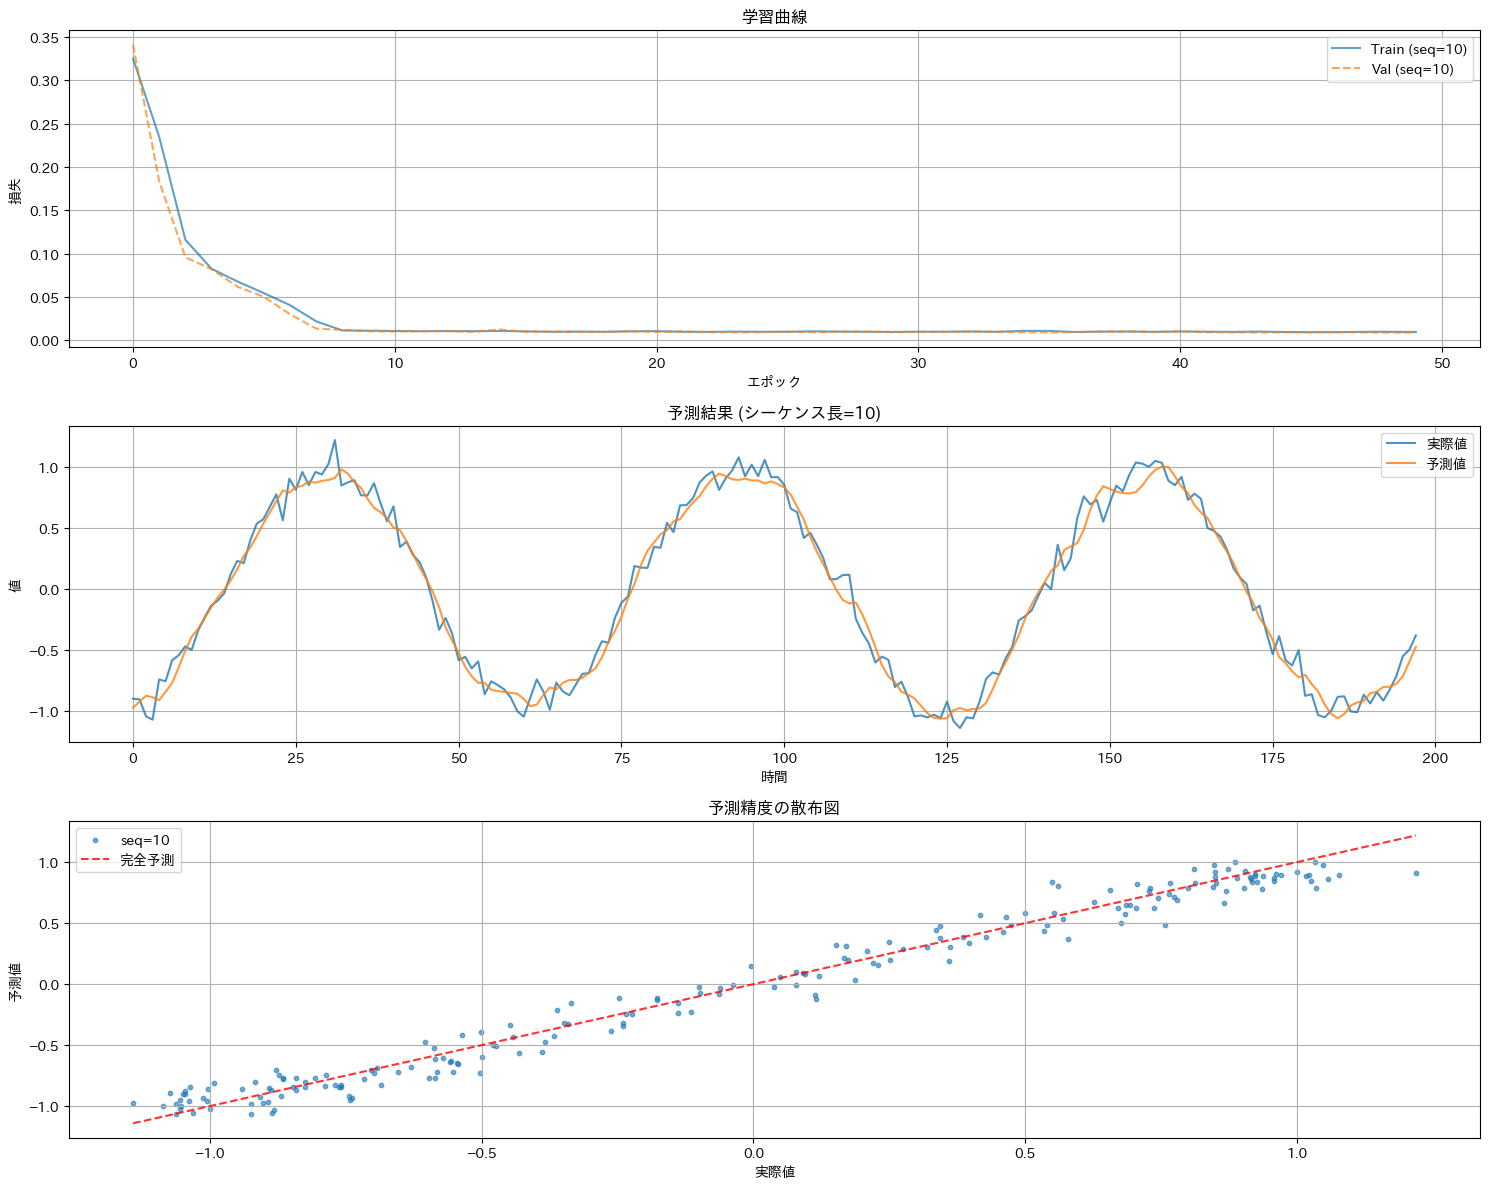

In [10]:
import matplotlib.pyplot as plt
import japanize_matplotlib

# 可視化関数
def plot_results(result):
    """
    実験結果を可視化する関数
    """
    # 1. 学習曲線の比較
    plt.figure(figsize=(15, 12))

    # 学習曲線
    plt.subplot(3, 1, 1)
    seq_len = result['sequence_length']
    plt.plot(result['train_losses'], label=f'Train (seq={seq_len})', alpha=0.7)
    plt.plot(result['val_losses'], label=f'Val (seq={seq_len})', linestyle='--', alpha=0.7)
    plt.title('学習曲線')
    plt.xlabel('エポック')
    plt.ylabel('損失')
    plt.legend()
    plt.grid(True)

    # 2. 予測結果の比較（最初の200ポイント）
    plt.subplot(3, 1, 2)
    seq_len = result['sequence_length']

    # 最初の200ポイントのみ表示
    n_display = min(200, len(result['predictions']))

    plt.plot(result['actuals'][:n_display], label='実際値', alpha=0.8)
    plt.plot(result['predictions'][:n_display], label='予測値', alpha=0.8)
    plt.title(f'予測結果 (シーケンス長={seq_len})')
    plt.xlabel('時間')
    plt.ylabel('値')
    plt.legend()
    plt.grid(True)

    # 3. 評価指標の比較
    '''
    plt.subplot(2, 3, 5)
    metrics_names = ['MSE', 'RMSE', 'MAE']
    seq_lengths = [result['sequence_length'] for result in results_list]

    for metric in metrics_names:
        values = [result['metrics'][metric] for result in results_list]
        plt.plot(seq_lengths, values, marker='o', label=metric)

    plt.title('評価指標の比較')
    plt.xlabel('シーケンス長')
    plt.ylabel('誤差')
    plt.legend()
    plt.grid(True)
    '''

    # 4. 散布図（予測精度の可視化）
    plt.subplot(3, 1, 3)
    seq_len = result['sequence_length']
    # サンプリングして表示
    n_sample = min(500, len(result['predictions']))
    idx = np.random.choice(len(result['predictions']), n_sample, replace=False)

    plt.scatter(result['actuals'][idx], result['predictions'][idx],
                alpha=0.6, label=f'seq={seq_len}', s=10)

    # 完全予測線
    all_actuals = result['actuals']
    min_val, max_val = all_actuals.min(), all_actuals.max()
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='完全予測')

    plt.title('予測精度の散布図')
    plt.xlabel('実際値')
    plt.ylabel('予測値')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_results(result)